In [12]:
##### Dataverse assignment - Telemachos ######
# The assignment was done in Google Colab

# Import neccessary libraries and frameworks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
import os
import shap

Using TensorFlow backend.


In [ ]:
#!pip install pyspark

     |████████████████████████████████| 215.7MB 127kB/s 
     |████████████████████████████████| 204kB 44.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=762b0d15265d38744452abd8e751725c3cb0a99760a877af77566e65167c5e52
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [18]:
# Read data from excel file. Your path might differ from the given one.


data = pd.read_excel("fmincon_weather.xlsx")

In [7]:
### Split data for training, validation and testing

# Train-test data spliting

train_set, test = train_test_split(data, test_size=0.2)
train_set, val = train_test_split(train_set, test_size=0.2)

# Seperate the target label from features

target_train = train_set.pop('Set-point')
target_test = test.pop('Set-point')


In [8]:
### Hyperparameters of the model

lr = 0.01     # learning rate
epochs = 100
nl1 = 128     # neurons of the first layer
nl2 = 64       # neurons of the second layer
nl3 = 1       # neurons of the third layer
batch_size = 64

### Activation functions

# Select 0 for relu, 1 for sigmoid

actf = ["relu", "sigmoid"] 

### Optimizers

# Select 0 for SGD, 1 for Adam

optim = [tf.keras.optimizers.SGD(lr), tf.keras.optimizers.Adam(lr)] 

### Loss functions

# Pearson correllation loss function.
def Pcorr(y_true, y_pred):
  x = y_true
  y = y_pred
  mx = K.mean(x)
  my = K.mean(y)
  xm, ym = x-mx, y-my
  r_num = K.sum(tf.multiply(xm,ym))
  r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
  r = r_num / r_den

  r = K.maximum(K.minimum(r, 1.0), -1.0)
  return 1 - K.square(r)
  
# Select 0 for Mean Squared Error, 1 for Mean Absolute Error, 2 for Pearson Correlation, 3 for Numpy Correllation

lossf = ['mse', 'mae', Pcorr]

In [9]:
# Define the model 

class nn():
  def __init__(self, actf1, actf2, opt, lossf):
    self.activ1 = actf1
    self.activ2 = actf2
    self.optim = opt
    self.losf = lossf
    
  def build(self):
    model = keras.Sequential([
        layers.Dense(nl1, activation= self.activ1, input_shape = [3]),
        layers.Dense(nl2, activation= self.activ2),
        layers.Dense(nl3)
    ])
  
  
    model.compile(loss =self.losf,
              optimizer = self.optim,
              metrics = lossf)
    return model



In [13]:
### Build the model. 
# You can change the activation (1st argument), optimizer (2nd arg) and loss function (3nd arg)
# by changing the numbers of each list in line 5.
  
model = nn(actf[0], actf[0], optim[0], lossf[1])
net = model.build()

In [14]:
# Train the model

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
history=net.fit(
    train_set, 
    target_train, 
    epochs = epochs, 
    batch_size = batch_size,
    validation_split=0.2,
    verbose = 0,
  callbacks=[PrintDot()])

ValueError: Error when checking input: expected dense_3_input to have shape (3,) but got array with shape (4,)

In [ ]:
### Visualize the results

# Parameters of the model

def model_var():
  print("The parameters of this model was: " )
  print("- Learning rate: ", lr)
  print("- Number of epochs: ", epochs)
  print("- Number of neurons of the first layer:", nl1)
  print("- Number of neurons of the second layer:", nl2)
  print("- Batch size:", batch_size)
  print("- The activation function of the first layer was",model.activ1)
  print("- The activation function of the second layer was",model.activ2)

  print("- The optimizer was", model.optim)
  print("- The loss function was",model.losf)
  print("- The metrics for the model evaluation was",lossf)
  print("\n")
  net.summary()

  
model_var()


The parameters of this model was: 
- Learning rate:  0.01
- Number of epochs:  100
- Number of neurons of the first layer: 128
- Number of neurons of the second layer: 64
- Batch size: 64
- The activation function of the first layer was relu
- The activation function of the second layer was relu
- The optimizer was <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fa727fa1940>
- The loss function was mae
- The metrics for the model evaluation was ['mse', 'mae', <function Pcorr at 0x7fa72b0eee18>]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6


 Plots


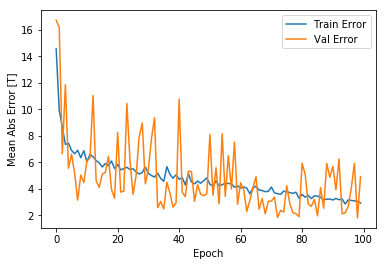

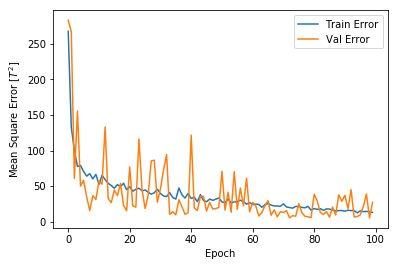

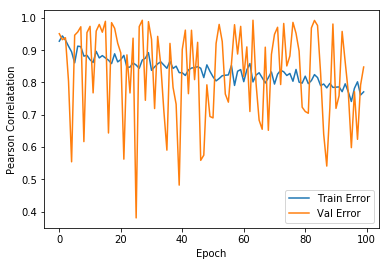

In [ ]:
# Plots of the metrics

def plots():
  print("\n Plots")
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

    # Mean Absolute Error
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [T]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
 # plt.ylim([.4,1])
  plt.legend()

    # Mean Squared Error
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$T^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([.4,1.4])
  plt.legend()

    # Pearson Correllation
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Pearson Correlatation')
  plt.plot(hist['epoch'], hist['Pcorr'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_Pcorr'],
           label = 'Val Error')
 # plt.ylim([0,1])
  plt.legend()

  plt.show()

plots()

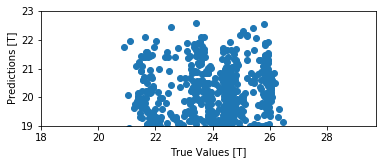

In [ ]:
# Predictions of the trained model

def predict():
  predictions = net.predict(test).flatten()

  plt.scatter(target_test, predictions)
  plt.xlabel('True Values [T]')
  plt.ylabel('Predictions [T]')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([18, plt.xlim()[1]])
  plt.ylim([19, plt.ylim()[1]])
  #_= plt.plot([-100,100], [-100,100])


predict()

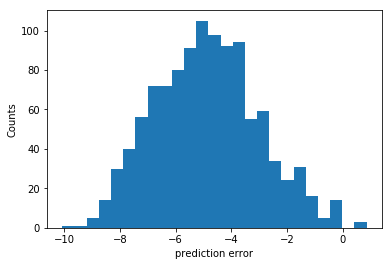

In [ ]:
# Histogram

def histg():
  predictions = net.predict(test).flatten()
  error = predictions - target_test
  plt.hist(error, bins=25)
  plt.xlabel("prediction error")
  _= plt.ylabel("Counts")
  
histg()

In [ ]:
### Validation of the algorithm (Shapley values)

# I used the Tree explainer from the shap package

# load JS visualization code to notebook
shap.initjs()

# pick type of network
clf= tree.DecisionTreeRegressor()

# train the network
clf=clf.fit(train_set,target_train)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_set)

# visualize the first prediction's explanation 
shap.force_plot(explainer.expected_value, shap_values[0,:], train_set.iloc[0,:])

In [ ]:
# visualize the training set predictions

shap.initjs() # you need this again for some reason

shap.force_plot(explainer.expected_value, shap_values, train_set)

/usr/local/lib/python3.6/dist-packages/shap/plots/force.py:141: UserWarning: shap.force_plot is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow for many thousands of rows, try subsampling your data.")


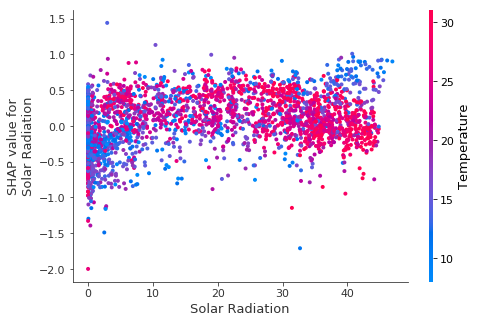

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
# Choose between "Temperature", "Solar Radiation" and "Humidity"

features = ['Temperature', 'Solar Radiation', 'Humidity']
shap.dependence_plot(features[1], shap_values, train_set) 

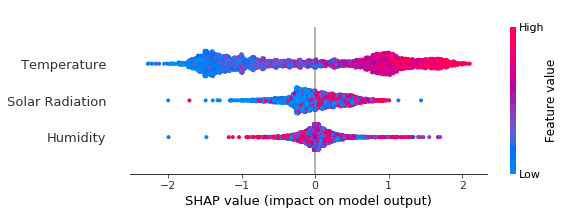

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_set)

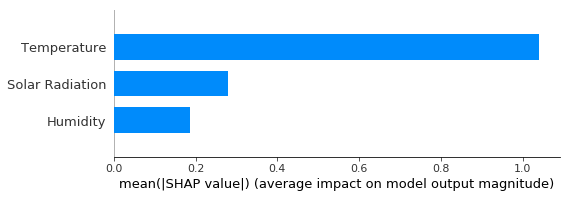

In [ ]:
# MAE of SHAP values for each feature
shap.summary_plot(shap_values, train_set, plot_type="bar")

In [ ]:
# Now, I'll use a different method for data splitting but since it requires 
# a different model architecture I'll continue here.

# KFold data spliting

kf = KFold(n_splits=10, random_state=0)
train_set = data.loc[:, 'Temperature':'Solar Radiation']
target_train = data['Set-point']

In [ ]:
# I'll use the same model I defined earlier
 
  # Train the model
# You can change the activation (1st argument), optimizer (2nd arg) and loss function (3nd arg)
# by changing the numbers of each list in line 8.

for train, test in kf.split(train_set, target_train):
  modelkf = nn(actf[1], optim[0], lossf[1])
  netkf = modelkf.build()
  history=netkf.fit(
          train_set.loc[train], 
          target_train.loc[train], 
          epochs = epochs, 
          batch_size = batch_size,
          validation_split=0.2,
          verbose = 0)
  

In [ ]:
# Visualization of the results, evaluation of the model

model_var()

The parameters of this model was: 
- Learning rate:  0.01
- Number of epochs:  100
- Number of neurons of the first layer: 128
- Number of neurons of the second layer: 1
- Batch size: 64
- The activation function of the first layer was sigmoid
- The optimizer was <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8b6c9dbe48>
- The loss function was mae
- The metrics for the model evaluation was ['mse', 'mae', <function Pcorr at 0x7f8b6d128bf8>, 'accuracy']


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________



 Plots


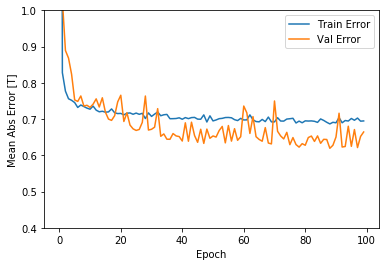

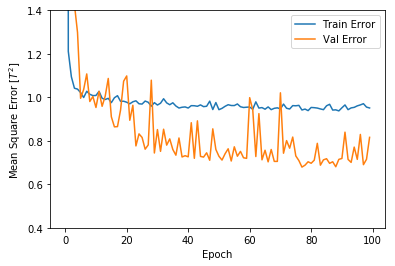

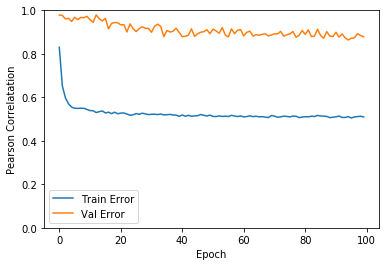

In [ ]:
plots()

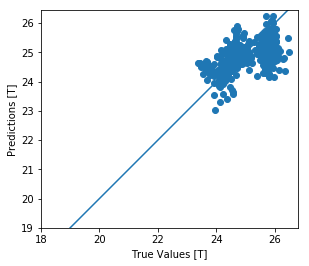

In [ ]:
# Predictions of the trained model

predictions = net.predict(train_set.loc[test]).flatten()

plt.scatter(target_train.loc[test], predictions)
plt.xlabel('True Values [T]')
plt.ylabel('Predictions [T]')
plt.axis('equal')
plt.axis('square')
plt.xlim([18, plt.xlim()[1]])
plt.ylim([19, plt.ylim()[1]])
_= plt.plot([-100,100], [-100,100])


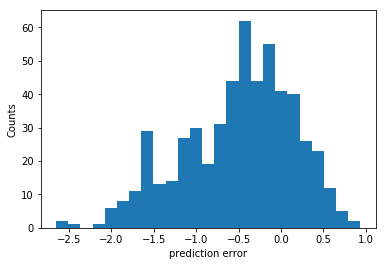

In [ ]:
#histogram

predictions = netkf.predict(train_set.loc[test]).flatten()
error = predictions - target_train.loc[test]
plt.hist(error, bins=25)
plt.xlabel("prediction error")
_= plt.ylabel("Counts")